In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
  !git config --global user.email "naiaseh@uwo.com"
  !git config --global user.name "Nadia Aiaseh"

In [ ]:
import os
os.chdir("/content/drive/MyDrive/Trunk/PinnNew")
print(os.getcwdb())

b'/content/drive/MyDrive/Trunk/PinnNew'


In [ ]:
!git add KP.ipynb
!git commit -m "Yconfig solution approximate convergence"
!git push origin main

[main c831675] Yconfig solution (somewhat) convergence
 1 file changed, 1 insertion(+), 1 deletion(-)
 rewrite PinnNew/KP.ipynb (62%)
Enumerating objects: 7, done.
Counting objects: 100% (7/7), done.
Delta compression using up to 8 threads
Compressing objects: 100% (4/4), done.
Writing objects: 100% (4/4), 1.25 MiB | 2.92 MiB/s, done.
Total 4 (delta 3), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (3/3), completed with 3 local objects.
To https://github.com/naiaseh/Trunk.git
   a74ca63..c831675  main -> main


In [ ]:
from modules.models import KPPinn, create_dense_model, create_dense_model_Normalized, FourierFeatures
from modules.data import simulate_KP
from modules.plots import plot_KdV_model, plot_training_loss
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pickle
import imageio

In [ ]:

phi = 0



def boundary_function(txy):
    return phi*tf.ones_like(txy[:, 1:2])




In [ ]:

### NOTES ####
# c/2 = 2k^2
# lamb = 2*tf.tan(angle_y_axis) where angle_y_axis is CCW from the positive y axis.

x_start =  -20. #-10
length = 20.#10
y_start = x_start
ylength = length
t0 = 0.
time = 15.

def phi_function2(txy):

  k1 = 1/2.
  k2 = 1.
  c = k1**2*4
  c2 = k2**2*4


  offset =  0.
  offset2 =  0.



  vert_offset1, vert_offset2 = +30., 30.



  lamb = 3./4. # if this is negative it'll be CW
  lamb2 = 1./4.

  eta1 = k1*((txy[:, 1:2] + offset) + lamb * (txy[:,2:3] + vert_offset1) - (k1**2+3*lamb**2) *txy[:,0:1] )
  eta2 = k2*((txy[:, 1:2] + offset2) + lamb2 * (txy[:,2:3] + vert_offset2) - (k2**2+3*lamb2**2) * txy[:,0:1])


  eA12 =( (k1-k2)**2 - (lamb-lamb2)**2)/((k1+k2)**2 - (lamb-lamb2)**2)


  deriv_term1 = (k1**2 * tf.math.exp(eta1) + k2**2 * tf.math.exp(eta2) + eA12 * (k1+k2)**2 * tf.math.exp(eta1+eta2)) / (1 + tf.math.exp(eta1) + tf.math.exp(eta2) + eA12 * tf.math.exp(eta1+eta2))
  deriv_term2 = (k1 * tf.math.exp(eta1) + k2 * tf.math.exp(eta2) + eA12 * (k1+k2) * tf.math.exp(eta1+eta2))**2 / (1 + tf.math.exp(eta1) + tf.math.exp(eta2) + eA12 * tf.math.exp(eta1+eta2))**2

  u2 = 2*(deriv_term1 - deriv_term2)
  u2 = tf.where(tf.math.is_nan(u2), 0., u2)

  return u2



(300, 3)
my shape tf.Tensor([90000     1], shape=(2,), dtype=int32) tf.Tensor([300 300], shape=(2,), dtype=int32)


Text(0.5, 1.0, 'wave cross section at y = 0')

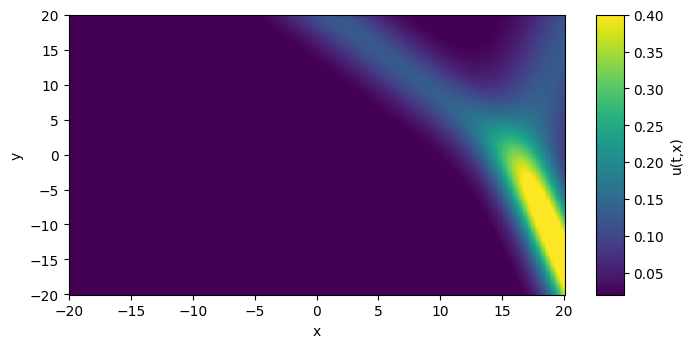

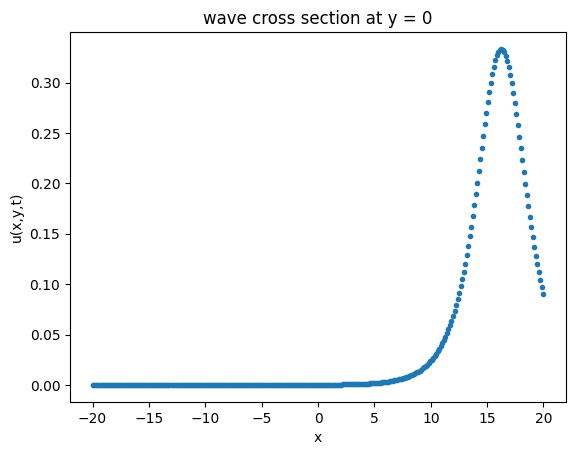

In [ ]:
from matplotlib.gridspec import GridSpec
N = 300
TIME = 20.
xt = np.linspace(x_start,length,N).T
yt = np.linspace(y_start,ylength,N).T
tt = np.zeros((N,1))
xt = xt.reshape(-1,1)
yt = yt.reshape(-1,1)
tt = tt.reshape(-1,1)

txy_test = np.c_[tt,xt,yt]
print(txy_test.shape)
txy_test = tf.convert_to_tensor(txy_test, dtype = 'float32')
txy_test = tf.reshape(txy_test, [N,3])

x, y = np.meshgrid(xt, yt)
txy = np.stack([np.full(x.flatten().shape, TIME), x.flatten(), y.flatten()],axis=-1)
fig = plt.figure(figsize=(8,8))

gs = GridSpec(2, 5)
plt.subplot(gs[0, :])

ut = phi_function2(txy)
print('my shape',tf.shape(ut), tf.shape(x))
ut = tf.reshape(ut, [x.shape[0],x.shape[1]])
plt.pcolormesh(x, y, ut)
plt.xlabel('x')
plt.ylabel('y')
cbar = plt.colorbar(pad=0.05, aspect=10)
cbar.set_label('u(t,x)')
# cbar.mappable.set_clim( tf.reduce_min(ut), tf.reduce_max(ut))
cbar.mappable.set_clim( 0.02, 0.4)
fig = plt.figure()

cross_sect = 0

txy2 = np.stack([np.full(tt.shape, TIME),  xt , np.full(tt.shape, cross_sect)], axis=1)
u2 = phi_function2(txy2)
u2 = tf.reshape(u2, [xt.shape[0],xt.shape[1]])
plt.plot(xt, u2, '.',label = 'exact at time {}'.format(0))

plt.xlabel('x')
plt.ylabel('u(x,y,t)')
plt.title('wave cross section at y = {}'.format(cross_sect))

In [ ]:
# when boundary function is set to None, the data will be collected from the phi_function but at boundary

(txy_eqn, u_eqn), (txy_init, u_phi), (txy_boundary_x, u_bnd_x), (txy_boundary_y, u_bnd_y), (x_bnd_left, x_bnd_right), (y_bnd_left, y_bnd_right)  = \
 simulate_KP(1333334, phi_function2, None, time, x_start, length, y_start, ylength, n_bnds = None,\
n_init = None, tstart = t0, random_seed = 42, dtype=tf.float32)

In [ ]:
normalizer = tf.keras.layers.Normalization(axis=1)
normalizer.adapt(txy_eqn)



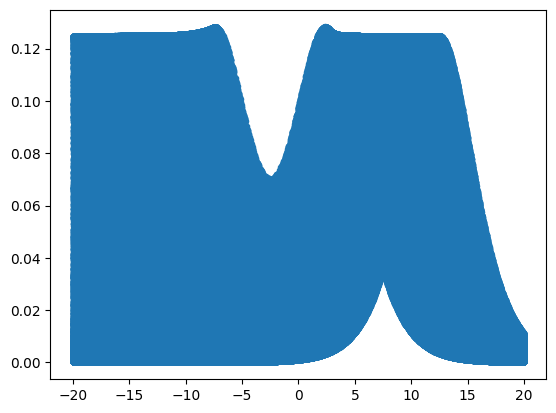

In [ ]:

plt.plot(txy_init[:,1:2],u_phi,'.')

inputs = [txy_eqn, txy_init, txy_boundary_x, x_bnd_right, x_bnd_left, txy_boundary_y, y_bnd_right, y_bnd_left]
outputs = [phi_function2(txy_eqn), u_eqn, u_phi, u_bnd_x, u_bnd_y]


In [ ]:

backbone = create_dense_model_Normalized([12, 24, 24, 24, 24, 12] , activation= 'tanh', initializer='glorot_normal', \
    n_inputs=3, n_outputs=1, normalizer=normalizer)
pinn = KPPinn(backbone, k=6., sig_sq = +3., PBC_y = False)
scheduler = tf.keras.optimizers.schedules.ExponentialDecay(1e-3, decay_steps=500, decay_rate=0.85)
optimizer = tf.keras.optimizers.Adam(learning_rate=scheduler, clipnorm=1.)
pinn.compile(optimizer=optimizer)

In [ ]:

history = pinn.fit(inputs, outputs, batch_size= 75000, epochs = 2000, verbose ='auto')

Epoch 1/2000
18/18 [==============================] - 56s 101ms/step - loss_total: 0.0148 - loss_residual: 1.9821e-06 - loss_initial: 0.0042 - loss_boundary: 0.0041 - loss_boundary_y: 0.0065 - mean_absolute_error: 0.0546
Epoch 2/2000
18/18 [==============================] - 2s 101ms/step - loss_total: 0.0075 - loss_residual: 6.2937e-07 - loss_initial: 0.0017 - loss_boundary: 0.0013 - loss_boundary_y: 0.0046 - mean_absolute_error: 0.0392
Epoch 3/2000
18/18 [==============================] - 2s 100ms/step - loss_total: 0.0063 - loss_residual: 6.5465e-07 - loss_initial: 0.0013 - loss_boundary: 0.0010 - loss_boundary_y: 0.0039 - mean_absolute_error: 0.0366
Epoch 4/2000
18/18 [==============================] - 2s 99ms/step - loss_total: 0.0058 - loss_residual: 6.4827e-07 - loss_initial: 0.0012 - loss_boundary: 9.4436e-04 - loss_boundary_y: 0.0036 - mean_absolute_error: 0.0346
Epoch 5/2000
18/18 [==============================] - 2s 101ms/step - loss_total: 0.0054 - loss_residual: 6.2761e-07

In [ ]:
history2 = {k: history[k] for k in ('loss_total', 'loss_residual', 'loss_initial', 'loss_boundary', 'loss_boundary_y')}



Text(0, 0.5, 'MAE')

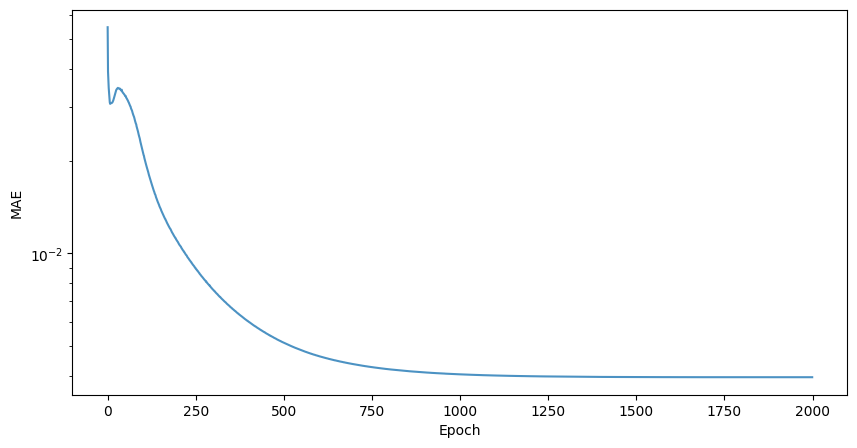

In [ ]:
plt.figure(figsize=(10, 5), dpi = 100)
plt.yscale('log')
plt.plot(history['mean_absolute_error'], label='mean absolute error', alpha = 0.8)
plt.xlabel('Epoch')
plt.ylabel('MAE')

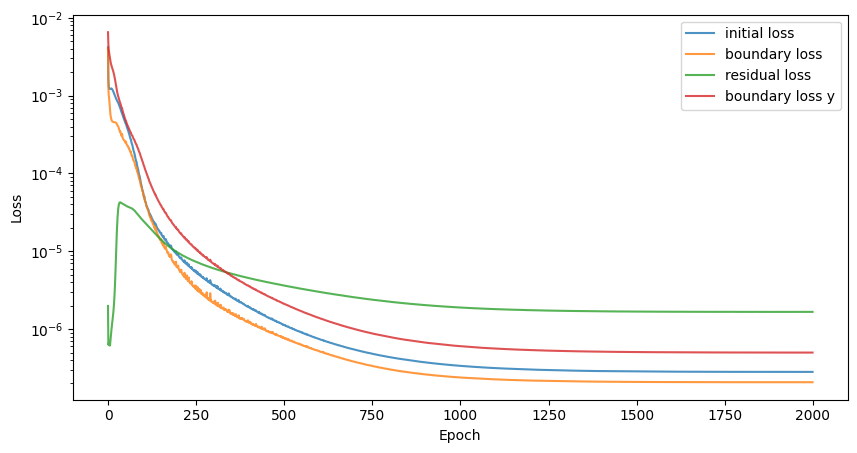

In [ ]:
plot_training_loss(history2, y_scale='log')

In [ ]:
from matplotlib.gridspec import GridSpec
def plot_snapshots(timeList,num_test_samples = 200, phi_function = None, cross_sect = 0):

    x_flat = np.linspace(x_start, length, num_test_samples)
    y_flat = np.linspace(y_start, ylength, num_test_samples)
    t_flat = np.linspace(0, time, num_test_samples)
    x_flat = tf.convert_to_tensor(x_flat)
    y_flat = tf.convert_to_tensor(y_flat)
    t_flat = tf.convert_to_tensor(t_flat)

    t_cross_sections = timeList
    for i, t_cs in enumerate(t_cross_sections):
        x, y = np.meshgrid(x_flat, y_flat)
        txy = np.stack([np.full(x.flatten().shape, t_cs), x.flatten(), y.flatten()],axis=-1)


        fig = plt.figure(figsize=(7,4))
        gs = GridSpec(2, 5)
        plt.subplot(gs[0, :])

        u = pinn.backbone.predict(txy, batch_size=num_test_samples)
        u = u.reshape(x.shape)
        plt.pcolormesh(x, y, u)
        plt.xlabel('x')
        plt.ylabel('y')
        cbar = plt.colorbar(pad=0.05, aspect=10)
        cbar.set_label('u(x,y,t)')
        cbar.mappable.set_clim(0., 0.3)
        # cbar.mappable.set_clim(tf.reduce_min(u), tf.reduce_max(u))
        plt.savefig(str(os.getcwdb())[2:-1]+"/PDFsKPIIYJunction/Time"+str(t_cs)+".pdf", format="pdf", bbox_inches="tight")
        fig = plt.figure()
        txy2 = np.stack([np.full(t_flat.shape, t_cs),  x_flat , np.full(t_flat.shape, cross_sect)], axis=-1)


        u2 = pinn.backbone.predict(txy2, batch_size=num_test_samples)
        uexact = phi_function(txy2)
        # uexact = tf.reshape(uexact, [x_flat.shape[0],x_flat.shape[1]])
        plt.plot(x_flat, u2, label = 'Prediction at time {}'.format(t_cs))
        plt.plot(x_flat, uexact, '.',label = 'Exact at time {}'.format(t_cs))
        plt.xlabel('x')
        plt.ylabel('u(x,y,t)')
        plt.legend()
        plt.title('wave cross section at y = {}'.format(cross_sect))

    return u2, x_flat


1/1 [==============================] - 0s 18ms/step


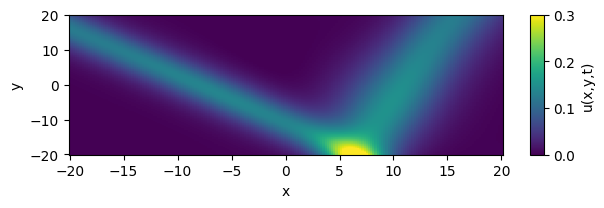

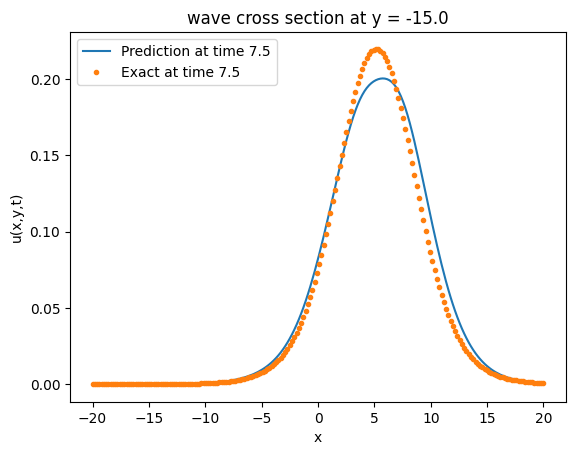

In [ ]:
u2pinn, xpinn = plot_snapshots([7.5], phi_function = phi_function2, cross_sect = -15.)